In [17]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import re

In [18]:
google_apps_file = "GooglePlaystore.xlsx"
goog = pd.read_excel(google_apps_file)

In [19]:
goog

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,2018-01-07 00:00:00,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,2018-01-15 00:00:00,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,2018-08-01 00:00:00,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,2018-06-08 00:00:00,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,2018-06-20 00:00:00,1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,2017-07-25 00:00:00,1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,2018-07-06 00:00:00,1,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,2017-01-20 00:00:00,1,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,2015-01-19 00:00:00,Varies with device,Varies with device


In [5]:
record = goog['Reviews'].astype(str) == '3.0M'
goog = goog.drop(goog[record].index)

In [6]:
rows = []
for i,row in goog.iterrows():
	if "Varies with device" in row.values:
		rows.append(i)
goog = goog.drop(rows)

In [7]:
goog["Android Ver"] = goog["Android Ver"].astype(str).str.extract(r"^(\d+\.\d+)")
goog["Android Ver"] = goog["Android Ver"].astype(float)

In [8]:
goog['Installs'] = goog['Installs'].astype(str).str.replace(',', '')
goog['Installs'] = goog['Installs'].str.replace('+', '')
goog = goog[goog["Installs"].str.isdigit()]
goog["Installs"] = goog["Installs"].astype(int)

In [9]:
rows = goog[(goog['Rating'].isna()) & (goog['Reviews'] < 100) & (goog['Installs'] < 50000)].index
goog = goog.drop(rows)
missing = goog[goog['Rating'].isna()]
category_avg = goog.groupby('Category')['Rating'].mean().round(2)
goog["Rating"] = goog.apply(lambda x: category_avg[x['Category']] if pd.isna(x['Rating']) else x['Rating'], axis=1)

In [10]:
def convert_size(size):
    size = str(size)
    if re.match(r"^\d+(\.\d+)?M$", size):
        return int(float(size[:-1]) * 1_000_000)
    elif re.match(r"^\d+(\.\d+)?K$", size):
        return int(float(size[:-1]) * 1_000)
    elif size == '0':
        return 0
    else:
        return np.nan

goog["Size"] = goog["Size"].apply(convert_size)

In [11]:
def top3_by_category(df, column):
    df.sort_values(by=column, ascending=False).groupby("Category").head(3)[["Category", "App", column]].reset_index(drop=True)
    return df.head(3)

free_apps = goog[goog['Type'] == 'Free']
top3_rating = top3_by_category(free_apps, 'Rating')
print(f"Top 3 apps by rating in each category: {top3_rating}")

top3_installs = top3_by_category(free_apps, 'Installs')
print(f"Top 3 apps by installs in each category: {top3_installs}")

top3_reviews = top3_by_category(free_apps, 'Reviews')
print(f"Top 3 apps by reviews in each category: {top3_reviews}")

Top 3 apps by rating in each category:                                                  App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   

  Reviews        Size  Installs  Type Price Content Rating  \
0     159  19000000.0     10000  Free     0       Everyone   
1     967  14000000.0    500000  Free     0       Everyone   
2   87510   8700000.0   5000000  Free     0       Everyone   

                      Genres         Last Updated Current Ver  Android Ver  
0               Art & Design  2018-01-07 00:00:00       1.0.0          4.0  
1  Art & Design;Pretend Play  2018-01-15 00:00:00       2.0.0          4.0  
2               Art & Design  2018-08-01 00:00:00       1.2.4          4.0  
Top 3 apps by installs in each category:                                           

In [12]:
paid_apps = goog[goog['Type'] == 'Paid']

avg_price = paid_apps['Price'].mean()
print(f"Average price: ${avg_price}")
max_price = paid_apps['Price'].max()
print(f"Maximum price: ${max_price}")
min_price = paid_apps['Price'].min()
print(f"Minimum price: ${min_price}")

Average price: $15.139163763066062
Maximum price: $400
Minimum price: $0.99


In [20]:
genres_col = goog['Genres']
split_genres = genres_col.str.split(';')
unique_genres = pd.Series([genre.strip() for sublist in split_genres.dropna() for genre in sublist]).unique()
unique_genres_list = unique_genres.tolist()
print(unique_genres_list)

['Art & Design', 'Pretend Play', 'Creativity', 'Action & Adventure', 'Auto & Vehicles', 'Beauty', 'Books & Reference', 'Business', 'Comics', 'Communication', 'Dating', 'Education', 'Music & Video', 'Brain Games', 'Entertainment', 'Events', 'Finance', 'Food & Drink', 'Health & Fitness', 'House & Home', 'Libraries & Demo', 'Lifestyle', 'Adventure', 'Arcade', 'Casual', 'Card', 'Action', 'Strategy', 'Puzzle', 'Sports', 'Music', 'Word', 'Racing', 'Simulation', 'Board', 'Trivia', 'Role Playing', 'Educational', 'Music & Audio', 'Video Players & Editors', 'Medical', 'Social', 'Shopping', 'Photography', 'Travel & Local', 'Tools', 'Personalization', 'Productivity', 'Parenting', 'Weather', 'News & Magazines', 'Maps & Navigation', 'Casino']


Text(0, 0.5, '')

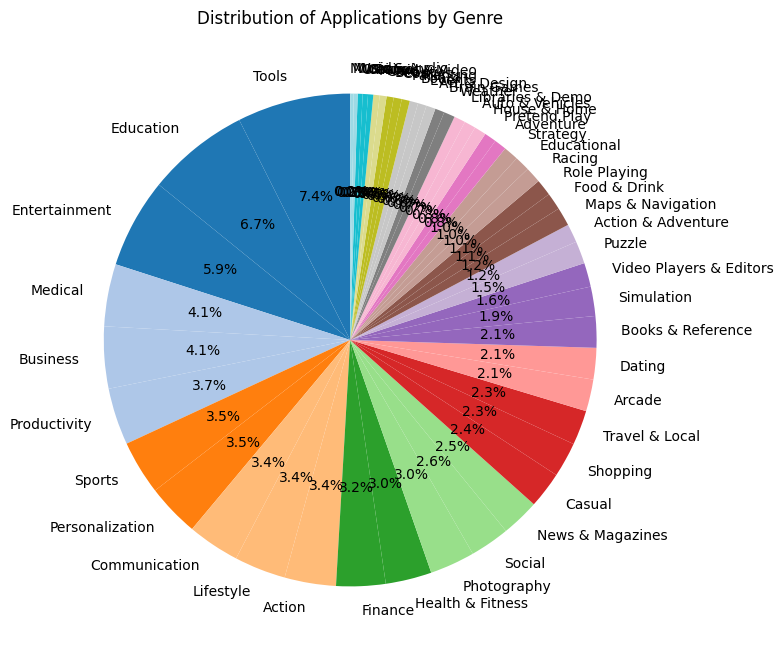

In [21]:
import matplotlib.pyplot as plt
goog['Genres'] = goog['Genres'].str.split(';')
exploded_genres = goog.explode('Genres')
genre_counts = exploded_genres['Genres'].value_counts()
plt.figure(figsize=(10, 8))
genre_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='tab20')
plt.title('Distribution of Applications by Genre')
plt.ylabel('') 

Text(0, 0.5, '')

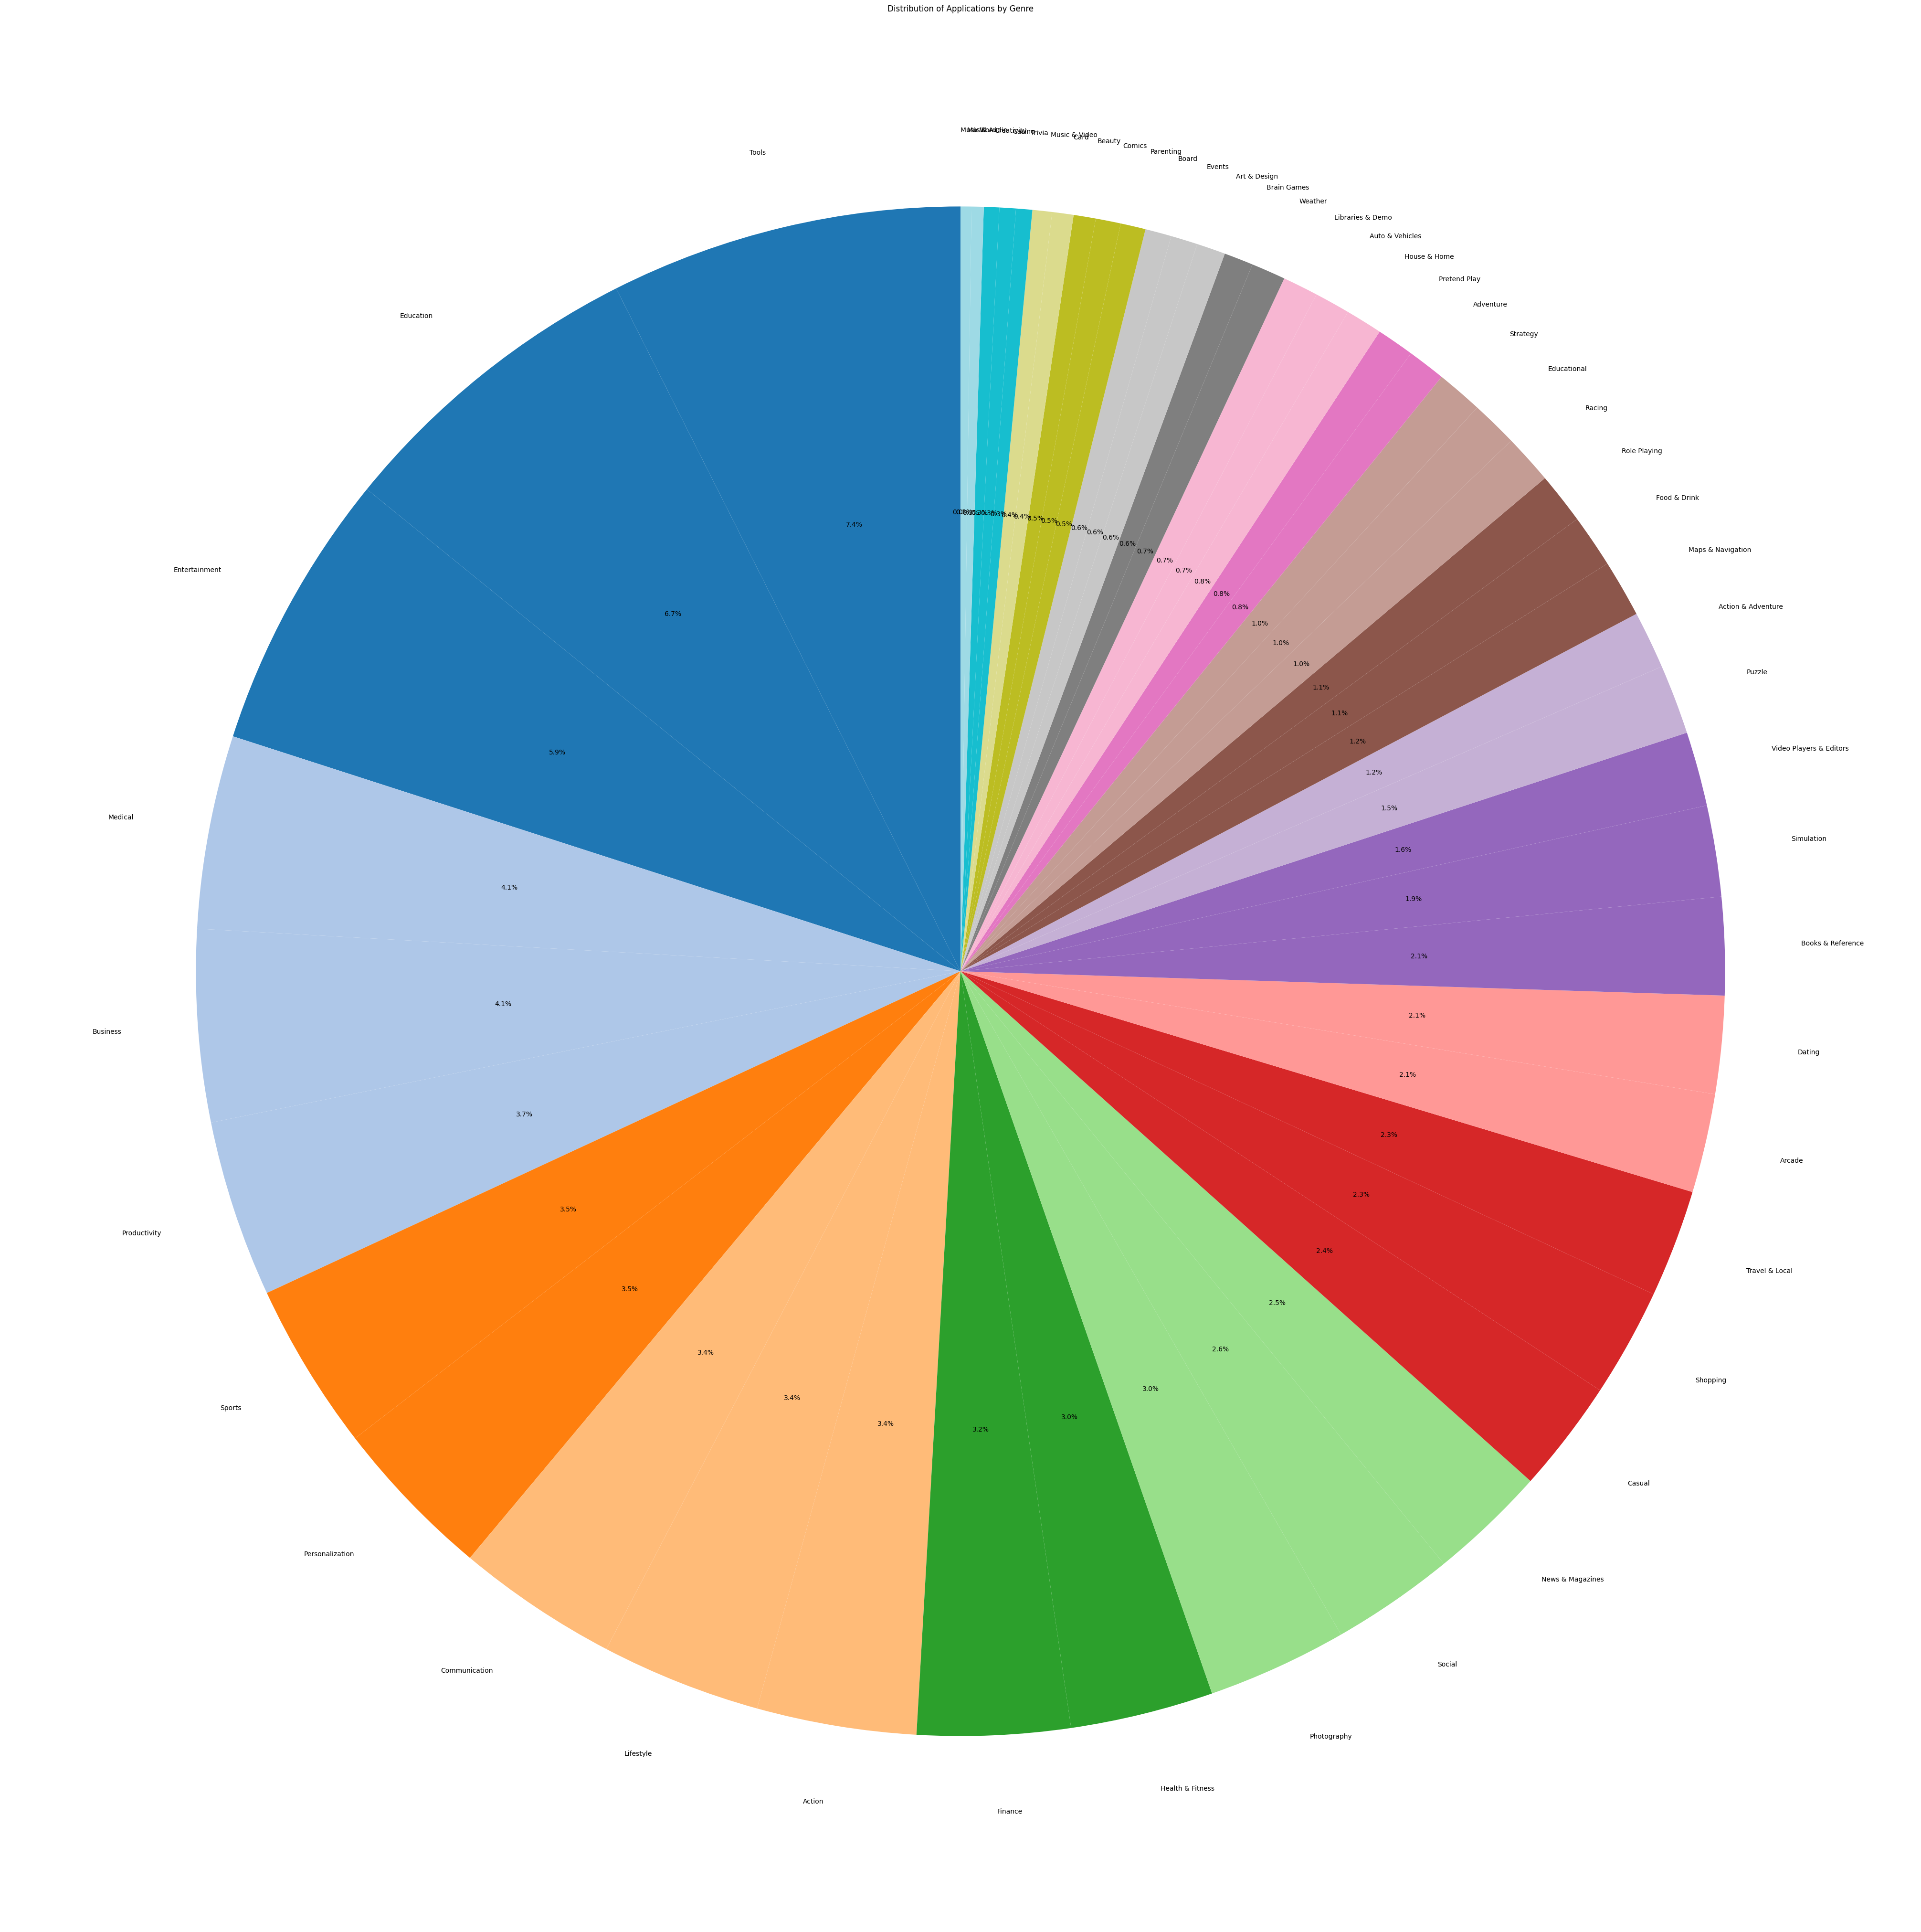

In [29]:
plt.figure(figsize=(60, 52))
genre_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='tab20')
plt.title('Distribution of Applications by Genre')
plt.ylabel('') #same plot more legible